In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from palettable.cartocolors.qualitative import Safe_4
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from pincast_verif import expected_calibration_error


In [3]:
SAVE = True
BASE_DIR = Path("../data/metrics/deuce_probabilistic_metrics")
SAVE_DIR = Path("../data/figures")

plt.style.use("bmh")
hex_colors = Safe_4.hex_colors
methods_params = {
    "steps" : {
        "color" : hex_colors[0], 
        "label" : "STEPS",
    },
    "bcnn" : {
        "label" : "DEUCE",
        "color" : hex_colors[2], 
    },
    "bcnn member" : {
        "label" : "DEUCE member",
        "color" : hex_colors[2],
        "linestyle": "dashed", 
    },
    "linda-p" : {
        "label" : "LINDA-P",
        "color" : hex_colors[1], 
    },
    "linda-d" : {
        "label" : "LINDA-D",
        "color" : hex_colors[1], 
    },
    "extrapolation" : {
        "label" : "Extrapolation",
        "color" : hex_colors[3], 
    },
}

In [4]:
roc = [xr.open_dataarray(p) for p in BASE_DIR.glob("*.nc") if "ROC" in str(p)]
roc = xr.Dataset(data_vars={arr.name : arr for arr in roc}) 

In [5]:
roc

<xarray.Dataset>
Dimensions:    (prob_thrs: 10, threshold: 4, leadtime: 4, quantity: 3)
Coordinates:
  * prob_thrs  (prob_thrs) float64 0.0 0.1111 0.2222 ... 0.7778 0.8889 1.0
  * threshold  (threshold) int32 20 25 35 45
  * leadtime   (leadtime) int32 1 3 6 12
  * quantity   (quantity) object 'POD' 'POFD' 'AUC'
Data variables:
    bcnn       (leadtime, threshold, quantity, prob_thrs) float64 ...
    linda-p    (leadtime, threshold, quantity, prob_thrs) float64 ...
    steps      (leadtime, threshold, quantity, prob_thrs) float64 ...

In [6]:
for model in roc:
    print(model, roc[model].sel(quantity="AUC").mean(dim=["leadtime","prob_thrs"]).values)

bcnn [0.96886467 0.96045793 0.88528672 0.70582141]
linda-p [0.94318791 0.92594619 0.84045739 0.68922755]
steps [0.9571432  0.93807323 0.78306887 0.60998852]


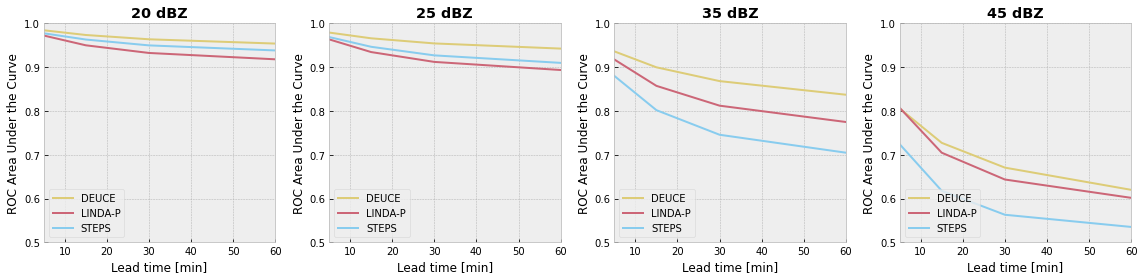

In [7]:
fig, axs = plt.subplots(ncols=len(roc.threshold), figsize=(4*len(roc.threshold),4))
lts = roc.leadtime.values*5
for i,thr in enumerate(roc.threshold):
    for model in roc:
        axs[i].plot(lts, roc[model].sel(threshold=thr,quantity="AUC").mean(dim="prob_thrs"), c=methods_params[model]["color"],label=methods_params[model]["label"])
    axs[i].set_xlim([5,60])
    axs[i].set_ylim([0.5,1])
    axs[i].set_ylabel("ROC Area Under the Curve")
    axs[i].set_xlabel("Lead time [min]")
    axs[i].set_title(f"{thr.values} dBZ",fontweight="semibold")
    axs[i].legend(loc="lower left")
fig.tight_layout()

if SAVE:
    fig.savefig(SAVE_DIR / "ROC_AUC_ALL.pdf", bbox_inches='tight')


In [8]:
reldiag = [xr.open_dataarray(p) for p in BASE_DIR.glob("*.nc") if "RELDIAG" in str(p)]
reldiag = xr.Dataset(data_vars={arr.name : arr for arr in reldiag}) 

In [9]:
reldiag

<xarray.Dataset>
Dimensions:    (bins: 10, threshold: 4, leadtime: 4, quantity: 3)
Coordinates:
  * bins       (bins) int32 0 1 2 3 4 5 6 7 8 9
  * threshold  (threshold) int32 20 25 35 45
  * leadtime   (leadtime) int32 1 3 6 12
  * quantity   (quantity) object 'forecast_probability' ... 'sample_size'
Data variables:
    bcnn       (leadtime, threshold, quantity, bins) float64 ...
    linda-p    (leadtime, threshold, quantity, bins) float64 ...
    steps      (leadtime, threshold, quantity, bins) float64 ...

new

In [10]:
for model in reldiag:
    for thr in reldiag.threshold:
        ece = np.mean(
            [
            expected_calibration_error(
            reldiag[model].sel(leadtime=lt, threshold=thr)
            ) for lt in reldiag.leadtime
            ]
        )
        print(f"{model}: {thr.values} dBZ : {np.round(ece*10**3,2)}")

bcnn: 20 dBZ : 6.88
bcnn: 25 dBZ : 5.36
bcnn: 35 dBZ : 1.97
bcnn: 45 dBZ : nan
linda-p: 20 dBZ : 13.36
linda-p: 25 dBZ : 8.44
linda-p: 35 dBZ : 2.04
linda-p: 45 dBZ : 0.23
steps: 20 dBZ : 9.45
steps: 25 dBZ : 6.64
steps: 35 dBZ : 1.13
steps: 45 dBZ : 0.15


In [11]:
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str, pos="top"):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    if pos == "top":
        row.set_title(f'{title}\n', fontweight='semibold',fontsize=10)
    elif pos == "left":
        row.set_title(f'{title}\n', fontweight='semibold',rotation="vertical",x=-0.03,y=0.4,fontsize=10)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

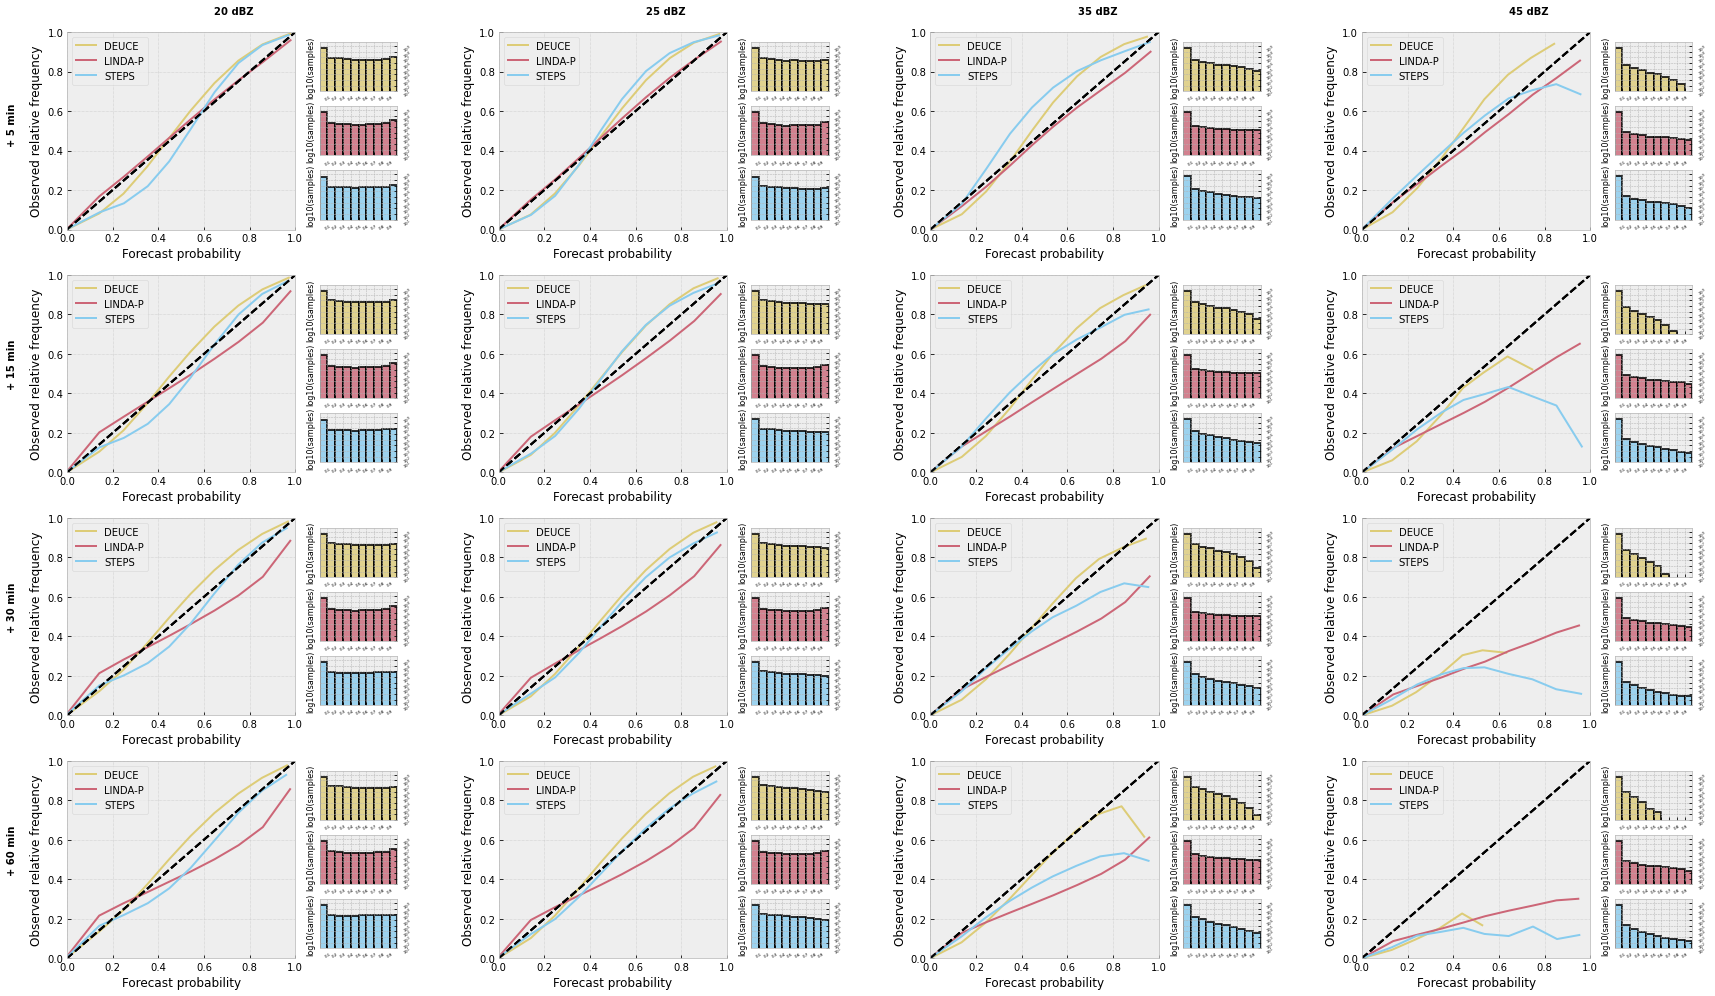

In [12]:
fig, axs = plt.subplots(
    nrows=len(reldiag.leadtime),
    ncols=len(reldiag.threshold),
    figsize=(6*len(reldiag.leadtime),3.5*len(reldiag.threshold))
)

for i,thr in enumerate(reldiag.threshold):
    for j,model in enumerate(reldiag):
        for k, lt in enumerate(reldiag.leadtime):
            div = make_axes_locatable(axs[k,i])
            sax = div.append_axes("right", size="40%", pad=0.2)
            sax.set_axis_off()
            r,f,num_sample = reldiag[model].sel(leadtime=lt,threshold=thr)
            mask = np.logical_and(np.isfinite(r), np.isfinite(f))

            axs[k,i].plot(
                r[mask],
                f[mask],
                color=methods_params[model]["color"],
                label=methods_params[model]["label"]
                )
            axs[k,i].plot([0, 1], [0, 1], "k--")

            axs[k,i].set_xlim(0, 1)
            axs[k,i].set_ylim(0, 1)

            axs[k,i].grid(True, ls=":")

            axs[k,i].set_xlabel("Forecast probability")
            axs[k,i].set_ylabel("Observed relative frequency")
            fig.add_axes(sax)
            axs[k,i].legend(loc="upper left")

            def match_loc(i : int):
                if i == 1:
                    return "upper left"
                elif i == 2:
                    return "center left"
                elif i == 3:
                    return "lower left"
                else:
                    raise ValueError()

            # Plot sharpness diagram into an inset figure.
            iax = inset_axes(sax, width="85%", height="25%", loc=match_loc(i=j+1), borderpad=1.0)
            bw = reldiag[model].attrs["bin_edges"][2] - reldiag[model].attrs["bin_edges"][1]
            iax.bar(
                reldiag[model].attrs["bin_edges"][:-1],
                num_sample,
                width=bw,
                align="edge",
                color=methods_params[model]["color"],
                edgecolor="black",
                linewidth=2,
                hatch=None,
                alpha=0.8
            )
            iax.set_yscale("log", base=10)
            iax.set_xticks(reldiag[model].attrs["bin_edges"])
            iax.set_xticklabels(["%.1f" % max(v, 1e-6) for v in reldiag[model].attrs["bin_edges"]])
            yt_min = int(max(np.floor(np.log10(min(num_sample[:-1]))), 1))
            yt_max = int(np.ceil(np.log10(max(num_sample[:-1]))))
            t = [pow(10.0, k) for k in range(1, 10)]

            iax.set_yticks([int(t_) for t_ in t])
            iax.set_xlim(0.0, 1.0)
            iax.set_ylim(t[0], 5 * t[-1])
            iax.set_ylabel("log10(samples)", fontsize=8)
            iax.yaxis.tick_right()
            iax.yaxis.set_label_position("left")
            iax.tick_params(axis="both", which="major", labelsize=4, rotation=30) #l

grid = plt.GridSpec(2, len(reldiag.threshold))
create_subtitle(fig, grid[::,0], '20 dBZ')
create_subtitle(fig, grid[::,1], '25 dBZ')
create_subtitle(fig, grid[::,2], '35 dBZ')
create_subtitle(fig, grid[::,3], '45 dBZ')

grid = plt.GridSpec(len(reldiag.threshold), 8)
create_subtitle(fig, grid[0,::], '+ 5 min', pos="left")
create_subtitle(fig, grid[1,::], '+ 15 min', pos="left")
create_subtitle(fig, grid[2,::], '+ 30 min', pos="left")
create_subtitle(fig, grid[3,::], '+ 60 min', pos="left")

fig.tight_layout()

if SAVE:
    fig.savefig(SAVE_DIR / "RELDIAG_ALL.pdf", bbox_inches='tight')